# General Deep Image Completion with LC GAN

In [1]:
import random

from PIL import Image
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from masks import *

In [2]:
IMAGE_SIZE = (256, 256)

## Build the generator

### Build semantic feature extraction (Encoder)

**Semantic Feature Extractor**: Given a corrupted image I with size H × W as input, we use a part of layers (before conv4-1) from VGG19 architecture as our semantic feature extractor (encoder) to obtain a high-level and semantic feature patch. To preserve image details, we replace all the pooling layer with strided convolutions as the pooling layer tens to lose some information in the reconstruction based networks. Also, we decrease the filter numbers of each layer to reduce the total model size.
Each convolution is followed by ELU activation that enhances the performance of the autoencoder.

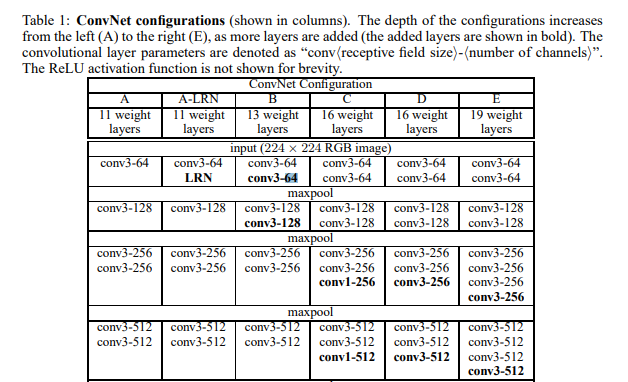

In [3]:
class SemanticFeatureExtractor(tf.keras.Model):
    def __init__(self):
        super(SemanticFeatureExtractor, self).__init__(name = 'SemanticFeatureExtractor')
        # Building table 1 VGG19 column B model's architecture
        
        # Row 1
        self.conv_3_32_1 = tf.keras.layers.Conv2D(32, kernel_size=3, padding='same')
        self.elu_1_1 = tf.keras.layers.ELU()

        self.conv_3_32_2 = tf.keras.layers.Conv2D(32, kernel_size=3, padding='same')
        self.elu_1_2 = tf.keras.layers.ELU()
        
        self.strided_conv_1 = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same')
        
        # Row 2
        self.conv_3_64_1 = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same')
        self.elu_2_1 = tf.keras.layers.ELU()
        
        self.conv_3_64_2 = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same')
        self.elu_2_2 = tf.keras.layers.ELU()
        
        self.strided_conv_2 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same')
        
        # Row 3

        self.conv_3_128_1 = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same')
        self.elu_3_1 = tf.keras.layers.ELU()
        
        self.conv_3_128_2 = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same')
        self.elu_3_2 = tf.keras.layers.ELU()
        
        self.conv_1_128 = tf.keras.layers.Conv2D(128, kernel_size=1, padding='same')
        self.elu_3_3 = tf.keras.layers.ELU()
        
        self.strided_conv_3 = tf.keras.layers.Conv2D(128, kernel_size=1, strides=2, padding='same')
        
    def call(self, tensor_input, training=False):
        # Row 1
        x = self.conv_3_32_1(tensor_input)
        x = self.elu_1_1(x)
        
        x = self.conv_3_32_2(x)
        x = self.elu_1_2(x)
        
        out_conv_1 = self.strided_conv_1(x)
        
        # Row 2
        x = self.conv_3_64_1(out_conv_1)
        x = self.elu_2_1(x)
        
        x = self.conv_3_64_2(x)
        x = self.elu_2_2(x)
        
        out_conv_2 = self.strided_conv_2(x)
        
        # Row 3
        x = self.conv_3_128_1(out_conv_2)
        x = self.elu_3_1(x)
        
        x = self.conv_3_128_2(x)
        x = self.elu_3_2(x)
        
        x = self.conv_1_128(x)
        x = self.elu_3_3(x)
        
        output = self.strided_conv_3(x)
        
        return output, out_conv_2, out_conv_1

Trainable parameters with an image of 256 x 256 pixels

In [4]:
model = SemanticFeatureExtractor()
model.build(input_shape=(None, 256, 256, 3))
model.summary()

Model: "SemanticFeatureExtractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
elu (ELU)                    multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  9248      
_________________________________________________________________
elu_1 (ELU)                  multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  9248      
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  18496     
_________________________________________________________________
elu_2 (ELU)                  multiple     

### Build the decoder

**Simple Generator**: Common deep encoder-decoder networks use symmetric structure
that extracts features and generates outcome through the same number of layers. However,
if the layer goes deeper, it would be difficult to train on GPUs efficiently due to explosion of
parameters and memory usage. In addition, the deeper structure in the decoder, the harder
to propagate learned feature information from the encoder. Therefore, we construct a simple
generator (or decoder) that takes the semantic feature patch as input and then reconstructs a
complete image in a short path. Our simple generator only contains two modules, and each
is formed of (convolution, fraction-strided convolution, ELU). Then, one convolution and
fraction-strided convolution is added at the end of the modules to produce the desired image.
Although our generator is short and simple, we can still obtain very good image reconstruction as long as we learn high-level and semantic feature patches through the encoder

In [5]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__(name = 'Decoder')

        self.deconv_1 = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')
        self.elu_1 = tf.keras.layers.ELU()
        
        self.deconv_2 = tf.keras.layers.Conv2DTranspose(32, kernel_size=3,strides=2, padding='same')
        self.elu_2 = tf.keras.layers.ELU()
        
        self.deconv_3 = tf.keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding='same')
        
    def call(self, input_tensor, training=False, **kwargs):
        x = self.deconv_1(input_tensor)
        x = self.elu_1(x)
        
        skip_1 = tf.keras.layers.concatenate([x, kwargs['strided_conv_2']], 3)
        
        x = self.deconv_2(skip_1)
        x = self.elu_2(x)
        
        skip_2 = tf.keras.layers.concatenate([x, kwargs['strided_conv_1']], 3)
        
        x = self.deconv_3(skip_2)
        
        return x

### Join the encoder and decoder

In [6]:
class Generator(tf.keras.Model): 
    def __init__(self):
        super(Generator, self).__init__(name = 'Generator')
        self.encoder = SemanticFeatureExtractor()
        self.decoder = Decoder()
        
    def call(self, input_tensor):
        x, out_conv_2, out_conv_1  = self.encoder(input_tensor)
        x = self.decoder(x, strided_conv_1=out_conv_1, strided_conv_2=out_conv_2)
        return x

In [7]:
model = Generator()
out = model.predict(np.random.uniform(0, 1, (1, 200, 200, 3)))

Generator working. Without training generates noise with noise

W0423 12:37:22.929903 17896 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


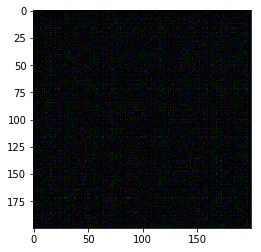

In [8]:
plt.imshow(out[0])

## Build the discriminator

In [9]:
class Discriminator(tf.keras.Model):
    def __init__(self, **kwargs):
        super(Discriminator, self).__init__(name='Discriminator', **kwargs)
        self.conv2d_1 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same")
        self.leaky_relu_1 = tf.keras.layers.LeakyReLU(alpha=.2)
        self.batch_norm_1 = tf.keras.layers.BatchNormalization(momentum=0.8)
        
        self.conv2d_2 = tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="same")
        self.leaky_relu_2 = tf.keras.layers.LeakyReLU(alpha=.2)
        self.batch_norm_2 = tf.keras.layers.BatchNormalization(momentum=0.8)
        
        self.conv2d_3 = tf.keras.layers.Conv2D(256, kernel_size=3, strides=2, padding="same")
        self.leaky_relu_3 = tf.keras.layers.LeakyReLU(alpha=.2)
        self.batch_norm_3 = tf.keras.layers.BatchNormalization(momentum=0.8)
        
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, input_tensor, training=False):
        x = self.conv2d_1(input_tensor)
        x = self.leaky_relu_1(x)
        x = self.batch_norm_1(x, training=training)
        
        x = self.conv2d_2(x)
        x = self.leaky_relu_2(x)
        x = self.batch_norm_2(x, training=training)
        
        x = self.conv2d_3(x)
        x = self.leaky_relu_3(x)
        x = self.batch_norm_3(x, training=training)
        
        x = self.flatten(x)
        return self.dense(x)

In [10]:
class LSGAN(tf.keras.Model):
    def __init__(self, discriminator, generator):
        super(LSGAN, self).__init__(name='LSGAN')

        self.discriminator = discriminator
        self.generator = generator
        
    def call(self, input_tensor):
        generated_image = self.generator(input_tensor)
        is_valid = self.discriminator(generated_image)
        return generated_image, is_valid

In [24]:
batch_size = 32
data_gen_args = dict(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.35
)

data_gen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

train_generator = data_gen.flow_from_directory(
    '../data/raw',
    batch_size=batch_size,
    class_mode=None,
    subset='training')

val_generator = data_gen.flow_from_directory(
    '../data/raw',
    batch_size=batch_size,
    class_mode=None,
    subset='validation')

Found 3250 images belonging to 1 classes.
Found 1750 images belonging to 1 classes.


In [ ]:
class_to_name = { v: k 
                     for k, v in 
                         list(train_generator.class_indices.items()) + 
                         list(val_generator.class_indices.items())
                }

In [26]:
optimizer = tf.keras.optimizers.Adam(0.0002, .5)

# Give fixed inputs to discriminator and generator
images = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
discriminator = Discriminator()
discriminator = tf.keras.Model(images, discriminator(images))

masked_images = tf.keras.layers.Input(shape=(None, None, 3))
generator = Generator()
generator = tf.keras.Model(masked_images, generator(masked_images))

# Join the discriminator and generator
lsgan = LSGAN(discriminator, generator)


# Compile the models
discriminator.compile(optimizer=optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

lsgan.compile(optimizer=optimizer,
              loss=['mae', 'binary_crossentropy'],
              loss_weights=[0.999, 0.001])

In [27]:
def mask_randomly(imgs):
    transformations = [drop_pixels, # Drop some random pixels
                       generate_lines_mask] # Draw vertical and horizontal lines over the image
    masked_imgs = np.empty_like(imgs)
    for i, img in enumerate(imgs):
        masked_imgs[i] = random.choice(transformations)(img)
        
    return masked_imgs

In [28]:
 def sample_images(epoch, masked_imgs, imgs):
    r, c = 3, 6

    gen_img, _ = lsgan.predict(masked_imgs)


    fig, axs = plt.subplots(r, c, figsize=(15, 10))
    for i in range(c):
        axs[0,i].imshow(imgs[i])
        axs[0,i].axis('off')
        axs[1,i].imshow(masked_imgs[i])
        axs[1,i].axis('off')
        axs[2,i].imshow(gen_img[i])
        axs[2,i].axis('off')
    plt.show()

In [29]:
def save(model, model_name):
    weights_path = "../models/%s_weights.hdf5" % model_name
    model.save_weights(weights_path)
    
def load(model, model_name):
    weights_path = "../models/%s_weights.hdf5" % model_name
    model.load_weights(weights_path)

In [30]:
load(discriminator, 'discriminator')
load(generator, 'generator')

0 [D loss: 1.967796, acc: 67.19%] [G loss: 0.078647, mse: 0.061318]


W0423 12:49:21.336193 17896 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0423 12:49:21.343196 17896 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0423 12:49:21.350194 17896 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0423 12:49:21.356194 17896 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0423 12:49:21.363196 17896 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0423 12:49:21.369197 17896 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


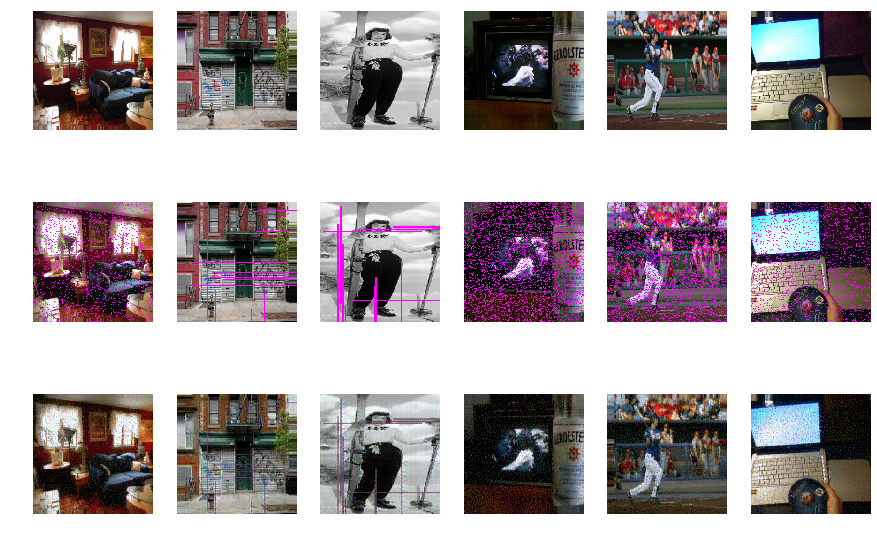

1 [D loss: 0.159768, acc: 95.31%] [G loss: 0.079463, mse: 0.061561]
2 [D loss: 1.499005, acc: 65.62%] [G loss: 0.061226, mse: 0.052387]
3 [D loss: 0.926028, acc: 79.69%] [G loss: 0.074282, mse: 0.054167]
4 [D loss: 0.197639, acc: 93.75%] [G loss: 0.074087, mse: 0.061125]
5 [D loss: 1.445840, acc: 76.56%] [G loss: 0.069044, mse: 0.057567]
6 [D loss: 0.181674, acc: 98.44%] [G loss: 0.069939, mse: 0.057841]
7 [D loss: 0.477834, acc: 76.56%] [G loss: 0.073753, mse: 0.060281]
8 [D loss: 0.468690, acc: 84.38%] [G loss: 0.077221, mse: 0.059777]
9 [D loss: 1.704009, acc: 64.06%] [G loss: 0.075288, mse: 0.062807]
10 [D loss: 0.398127, acc: 92.19%] [G loss: 0.074298, mse: 0.060212]
11 [D loss: 0.129426, acc: 98.44%] [G loss: 0.074179, mse: 0.061577]
12 [D loss: 1.200593, acc: 79.69%] [G loss: 0.073410, mse: 0.057288]
13 [D loss: 0.241624, acc: 89.06%] [G loss: 0.063088, mse: 0.054944]
14 [D loss: 1.120041, acc: 76.56%] [G loss: 0.077330, mse: 0.056453]
15 [D loss: 0.946300, acc: 79.69%] [G loss:

In [ ]:
# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(30000):
    original = train_generator.next()
    masked_images = mask_randomly(original)
    
    # Generate images
    gen = lsgan.generator.predict(masked_images)
    
    # Train discriminator with the generated images
    lsgan.discriminator.trainable = True
    d_loss_real = lsgan.discriminator.train_on_batch(original, valid)
    d_loss_fake = lsgan.discriminator.train_on_batch(gen, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # Train LSGAN
    lsgan.discriminator.trainable = False
    g_loss = lsgan.train_on_batch(masked_images, [original, valid])

    print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))
    
    if epoch % 50 == 0:
        original = val_generator.next()
        masked_images = mask_randomly(original)
        
        sample_images(epoch, masked_images, original)
        save(discriminator, "discriminator")
        save(generator, "generator")

    if epoch % 20 == 0:
        train_generator.reset()
        val_generator.reset()